# **1. Download or Clone YOLO Into Project Folder & Install Requirements**

In [1]:
!git clone https://github.com/ultralytics/yolov5
!rm -rf yolov5/.git/
!pip install -r yolov5/requirements.txt # Install YOLOv5 requirements
!pip install imutils

Cloning into 'yolov5'...
remote: Enumerating objects: 15002, done.
remote: Total 15002 (delta 0), reused 0 (delta 0), pack-reused 15002
Receiving objects: 100% (15002/15002), 14.08 MiB | 23.67 MiB/s, done.
Resolving deltas: 100% (10291/10291), done.
  Preparing metadata (setup.py) ... done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25858 sha256=89133e257d53ebe6411a877bb7372231591deb31b4fe8d2559e8abd8d371e925
  Stored in directory: /root/.cache/pip/wheels/86/d7/0a/4923351ed1cec5d5e24c1eaf8905567b02a0343b24aa873df2
Successfully built imutils


# **2. Imports**

In [2]:
import warnings 
warnings.filterwarnings('ignore') 

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
from matplotlib import pyplot
import seaborn as sns 
from PIL import Image
import os 
import tqdm.notebook as tq 
import random  
import cv2
from glob import glob

import keras 
from keras.models import Sequential 
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D 
from tensorflow.keras.layers import BatchNormalization 

# **3. Data Exploration**

In [3]:
dir1 = "/kaggle/input/hubnut-object-detection-dataset-1"
dir2 = "/kaggle/input/hubnut-object-detection-dataset-2"
dir3 = "/kaggle/input/hubnut-object-detection-dataset-3"

Total Number of images: 1334


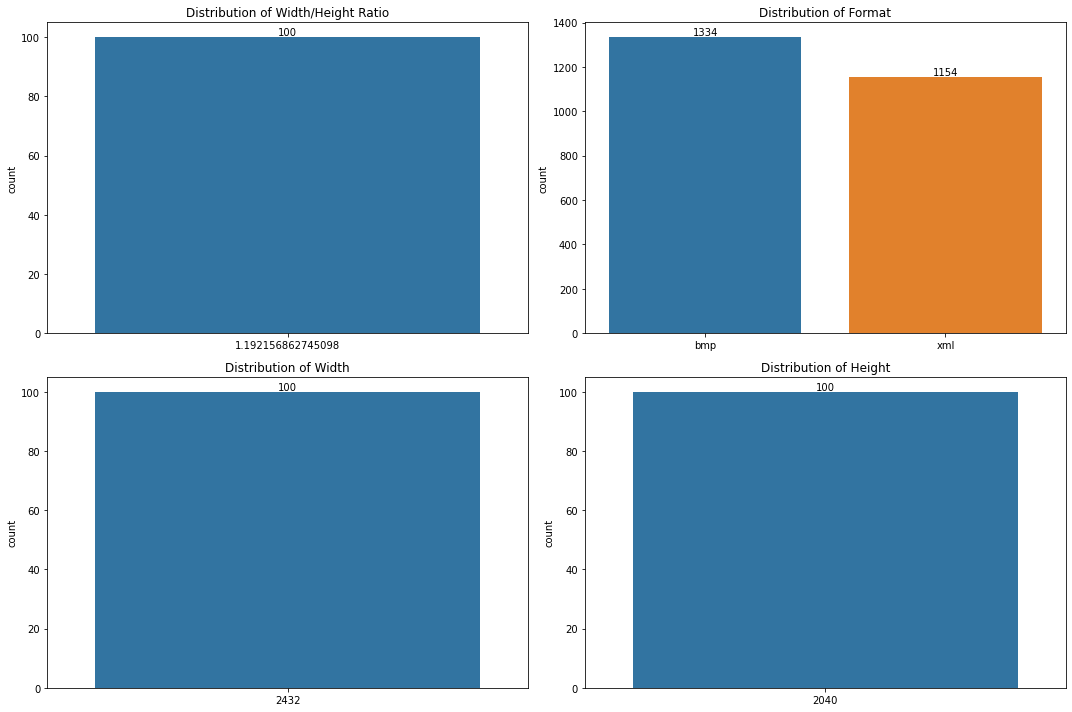

In [4]:
def plot_summary_graphs(*dir, num_samples=500): 
    graph_list = {"Width/Height Ratio":[],"Format":[],"Width":[],"Height":[]} 
    directories = [*dir] 
    images = sum([glob(os.path.join(i,j), recursive=True) for j in ("**/*.png","**/*.jpg","**/*.jpeg","**/*.bmp") for i in directories],[]) 
    all_files = sum([glob(os.path.join(i,'**/*.*'), recursive=True) for i in directories],[])
    graph_list["Format"] = [fp.split('.')[-1] for fp in all_files] 
    print('Total Number of images: %d'%len(images)) 
    samples = images if num_samples==0 else random.sample(images, num_samples) 
    for image in samples: 
        im = Image.open(image) 
        graph_list["Width"].append(im.size[0]) 
        graph_list["Height"].append(im.size[1]) 
        graph_list["Width/Height Ratio"].append(im.size[0]/im.size[1]) 
    plt.figure(figsize=(15,10)) 
    for i,k in enumerate(graph_list): 
        plt.subplot(2, 2, i+1) 
        ax = sns.countplot(x=graph_list[k]) 
        ax.bar_label(ax.containers[0]) 
        # counts, edges, bars = plt.hist(graph_list[k], align="mid") 
        # plt.bar_label(bars) 
        # plt.hist(graph_list[k], histtype='stepfilled', align='mid') 
        plt.title('Distribution of '+ k) 
    plt.tight_layout() 
    # plt.ticklabel_format(useOffset=False) # Prevents scientific notation (e.g 1.28e3)  
    plt.show() 

# set num_samples to 0 to check all dir 
plot_summary_graphs(dir1,dir2,dir3, num_samples=100)

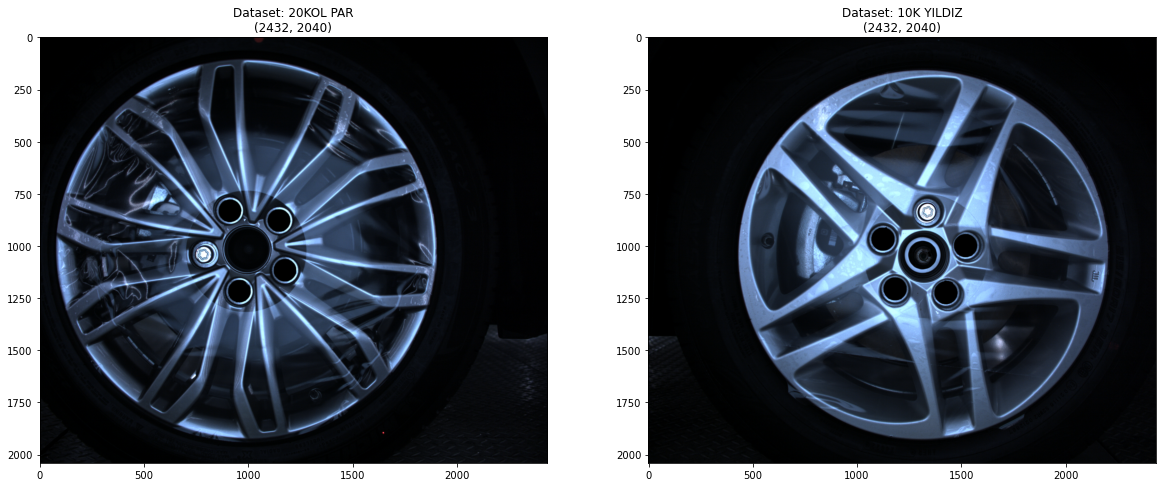

In [5]:
def plot_images_dirs(*dir, num_samples=5, num_cols=5, plot_gap=6):      
    directories = [*dir] 
    images = sum([glob(os.path.join(i,j), recursive=True) for j in ("**/*.png","**/*.jpg","**/*.jpeg","**/*.bmp") for i in directories],[]) 
    samples = images if num_samples==0 else random.sample(images, num_samples) 
    fig = plt.figure(figsize=(20,num_samples/num_cols*plot_gap))  
    for i,image in enumerate(samples): 
        plt.subplot(round(num_samples/num_cols),num_cols,i+1)    
        img = Image.open(image)    
        plt.title("Dataset: " + image.split("/")[-2] + "\n" + str(img.size))     
        plt.imshow(img)       
    plt.show() 

plot_images_dirs(dir1, num_samples=2, num_cols=2, plot_gap=9)

In [6]:
img_size = (1280,1280)

# **4. Loading Data**

In [7]:
import xml.etree.ElementTree as ET
def xmls2df(*xmls_dir, bbox_format="yolo"):
    directories = [*xmls_dir]
    xmls = sum([glob(os.path.join(i,'**/*.xml'), recursive=True) for i in directories], [])
    images = sum([glob(os.path.join(i,j), recursive=True) for j in ("**/*.png","**/*.jpg","**/*.jpeg","**/*.bmp") for i in directories],[])
    d_dict = dict(file_name=[],image_path=[],label=[],bboxes=[])
    for image in images:
        xml_path = sum([glob(os.path.join(i,'**/',os.path.split(image)[1].split(".")[0]+'.xml'), recursive=True) for i in directories],[])
        if len(xml_path) == 1: # If xml file (annotations) exist for that image, load annotations
            xml_path = xml_path[0]
            root = ET.parse(xml_path).getroot() # This line same for all formats, start from here 
            file_name = root.find("filename").text 
            width = int(root.find("size").find("width").text) 
            height = int(root.find("size").find("height").text) 
            objects = root.findall('object')
            annots,labels = [],[]
            if len(objects) > 0:
                for i,k in enumerate(objects):
                    if objects[i].find("name").text != 'OK DS NUT': # TO EXCLUDE SOME CLASS WHILE LOADING
                        class_name = objects[i].find("name").text
                        labels.append(class_name)
                        labels_info = objects[i].find('bndbox')
                        xmin = float(labels_info.find('xmin').text)
                        ymin = float(labels_info.find('ymin').text)
                        xmax = float(labels_info.find('xmax').text)
                        ymax = float(labels_info.find('ymax').text)
                        if bbox_format == "voc":
                            annots.extend([[xmin, ymin, xmax, ymax]])
                        elif bbox_format == "yolo":
                            annots.extend([[(xmin+(xmax-xmin)/2)/width, (ymin+(ymax-ymin)/2)/height, (xmax-xmin)/width, (ymax-ymin)/height]])
                        elif bbox_format == "albumentations":
                            annots.extend([[xmin/width, ymin/height, xmax/width, ymax/height]])
                d_dict["file_name"].append(file_name)
                d_dict["image_path"].append(image)
                d_dict["label"].append(labels)
                d_dict["bboxes"].append(annots)
            else: # if xml file not exist without any annotations, load only image
                d_dict["file_name"].append(os.path.split(image)[1])
                d_dict["image_path"].append(image)
                d_dict["label"].append([])
                d_dict["bboxes"].append([])
        else: # if xml file not exist for that image (image w/o annotations), load only image
            d_dict["file_name"].append(os.path.split(image)[1])
            d_dict["image_path"].append(image)
            d_dict["label"].append([])
            d_dict["bboxes"].append([])
    df = pd.DataFrame(d_dict)
    return df

In [8]:
df1 = xmls2df(dir1, bbox_format="yolo")
df2 = xmls2df(dir2, bbox_format="yolo")
df3 = xmls2df(dir3, bbox_format="yolo")

# **5. Merging Seperate Sets**

In [9]:
df = pd.concat([df1, df2, df3])
df = df.sample(frac=1).reset_index(drop=True) # Shuffle

In [10]:
len(df)

1334

# **6. Data Cleaning**

In [11]:
df.isna().any().any()

False

# **7. Exploratory Data Analysis**

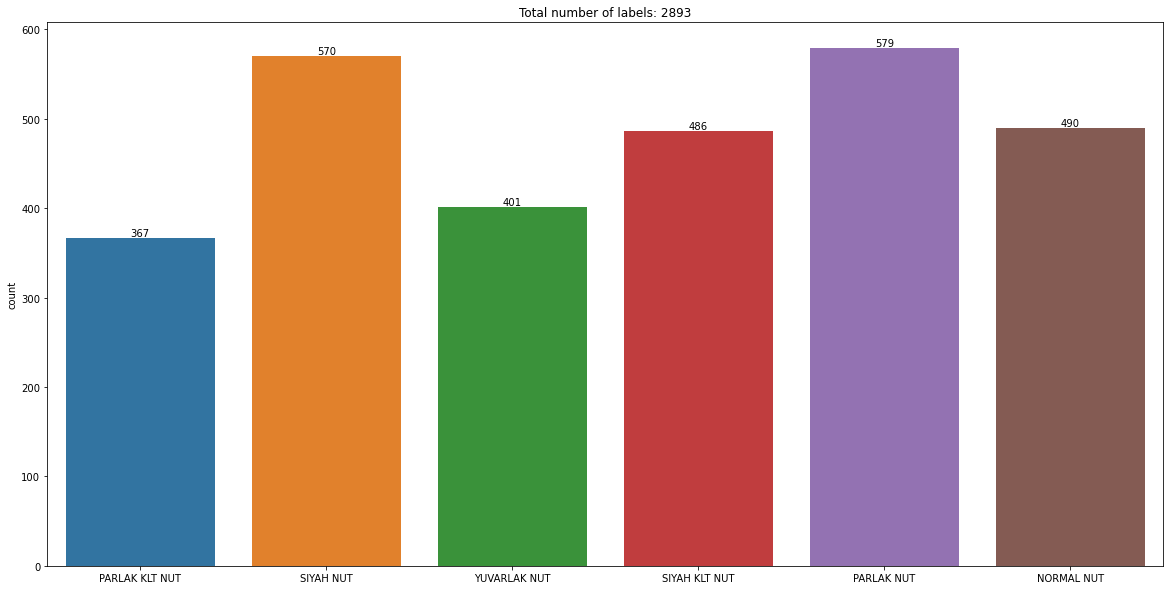

In [12]:
def plot_class_dist(*class_labels): 
    """ 
    Plot class distribution 
    class_labels: list or series of class labels 
    """ 
    fig = plt.figure(figsize=(20, 10)) 
    gs = fig.add_gridspec(len(class_labels),1) # Create subplots & specify (#rows, #columns) 
    gs.update(wspace=0.2, hspace=0.2) # Specify spaces between subplot (#rows, #columns) 
    for i in range(len(class_labels)): 
        ax = fig.add_subplot(gs[i, 0]) # Place plot on a subplot [row,column] 
        ax = sns.countplot(x=class_labels[i]) # For Array, use x=y, to change orientation: "x=" → "y=" 
        ax.bar_label(ax.containers[0]) # Show number on top of bars 
        ax.title.set_text(f"Total number of labels: {len(class_labels[i])}") 
        # dummy = ax.set_xticklabels(ax.get_xticklabels(), rotation=90) #If you have too much class, rotates x labels  

plot_class_dist([df["label"][i][j] for i in range(len(df["label"])) for j in range(len(df["label"][i]))]) 

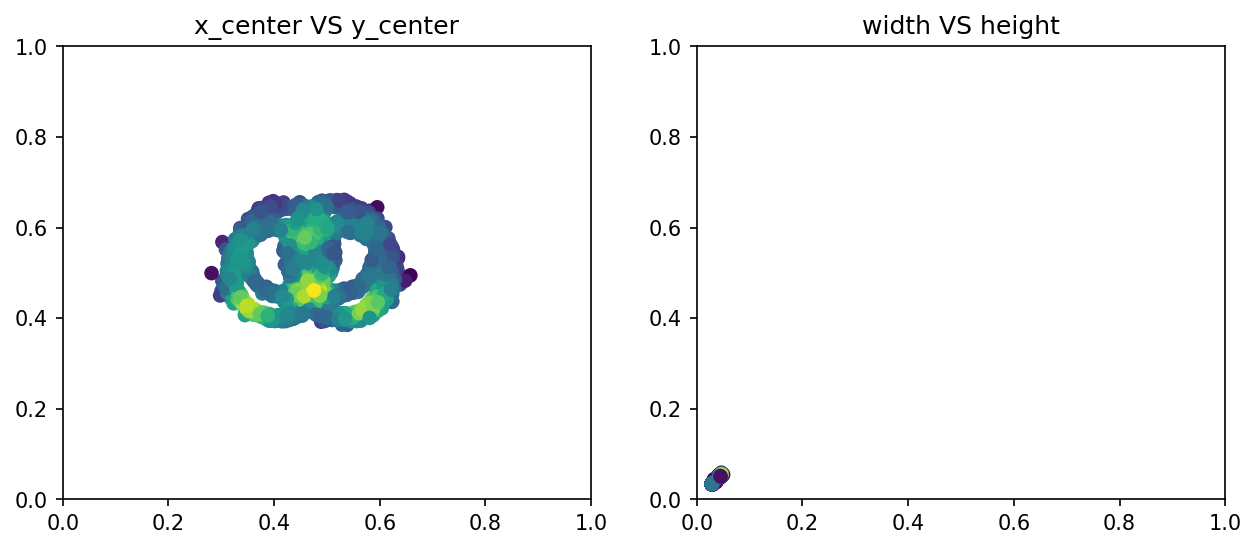

In [13]:
def plot_bbox_dist(df, bbox_format='yolo'):   
    """
    Plot bbox distribution
    df: Name of the Dataframe with following columns:
    • image_path: Path to the image (If bbox format is 'voc' or 'coco')
    • bboxes: Bboxes in YOLO [[xmid,ymid,w,h][xmid,ymid,w,h]] or VOC [[x,y,x,y][x,y,x,y]] format
    """
    if bbox_format=='yolo':
        x_mids = [df["bboxes"][i][k][0] for i in range(len(df)) for k in range(len(df["bboxes"][i]))]
        y_mids = [df["bboxes"][i][k][1] for i in range(len(df)) for k in range(len(df["bboxes"][i]))]
        widths = [df["bboxes"][i][k][2] for i in range(len(df)) for k in range(len(df["bboxes"][i]))]
        heights =[df["bboxes"][i][k][3] for i in range(len(df)) for k in range(len(df["bboxes"][i]))]
    elif bbox_format=='voc': 
        x_mids = [((df["bboxes"][i][k][2]+df["bboxes"][i][k][0])/2)/Image.open(df["image_path"][i]).size[0] for i in range(len(df)) for k in range(len(df["bboxes"][i]))]   
        y_mids = [((df["bboxes"][i][k][3]+df["bboxes"][i][k][1])/2)/Image.open(df["image_path"][i]).size[1] for i in range(len(df)) for k in range(len(df["bboxes"][i]))]   
        widths =  [(df["bboxes"][i][k][2]-df["bboxes"][i][k][0])/Image.open(df["image_path"][i]).size[0] for i in range(len(df)) for k in range(len(df["bboxes"][i]))]   
        heights = [(df["bboxes"][i][k][3]-df["bboxes"][i][k][1])/Image.open(df["image_path"][i]).size[1] for i in range(len(df)) for k in range(len(df["bboxes"][i]))]  
    elif bbox_format=='coco': 
        x_mids = [((df["bboxes"][i][k][2]+df["bboxes"][i][k][0])/2)/Image.open(df["image_path"][i]).size[0] for i in range(len(df)) for k in range(len(df["bboxes"][i]))]   
        y_mids = [((df["bboxes"][i][k][3]+df["bboxes"][i][k][1])/2)/Image.open(df["image_path"][i]).size[1] for i in range(len(df)) for k in range(len(df["bboxes"][i]))]   
        widths = [df['bboxes'][i][k][2]/Image.open(df["image_path"][i]).size[0] for i in range(len(df)) for k in range(len(df['bboxes'][i]))] 
        heights = [df['bboxes'][i][k][3]/Image.open(df["image_path"][i]).size[1] for i in range(len(df)) for k in range(len(df['bboxes'][i]))] 
     
    from scipy.stats import gaussian_kde   
    xy = np.vstack([x_mids,y_mids])   
    z = gaussian_kde(xy)(xy)   
    wh = np.vstack([widths,heights])   
    v = gaussian_kde(wh)(wh)   
  
    fig = plt.figure(figsize=(10, 4), dpi=150)    
    gs = fig.add_gridspec(1,2) # Create subplots & specify (#rows, #columns)    
    gs.update(wspace=0.2, hspace=0.2) # Specify spaces between subplot (#rows, #columns)    
    ax0 = fig.add_subplot(gs[0, 0]) # Place plot on a subplot [row_idx, column_idx]   
    ax1 = fig.add_subplot(gs[0, 1]) # Place plot on a subplot [row_idx, column_idx]   
    ax0.set(xlim=(0,1), ylim=([0,1])) # Set custom limits for graph   
    ax1.set(xlim=(0,1), ylim=([0,1])) # Set custom limits for graph   
   
    ax0.scatter(x_mids, y_mids, c=z, cmap='viridis')   
    ax0.set_title("x_center VS y_center")   
    ax1.scatter(widths, heights, c=v, cmap='viridis')   
    ax1.set_title("width VS height")   
    plt.show() 

plot_bbox_dist(df, bbox_format='yolo')

In [14]:
def get_bbox_outlier_indexes(x, y, num_huge=10, num_tiny=10, bbox_format="albumentations"): 
    """
    Finds outlier bboxes in dataframe or array
    x: Image array generated by cv2.imread("img.jpg")[..., ::-1] or image_path column of dataframe
    y: bbox array or bbox column of dataframe in this format → [[x,y,w,h], [x,y,w,h]]
    num_huge: Number of huge bbox outliers you want to see
    num_tiny: Number of tiny bbox outliers you want to see
    bbox_format: "albumentations", "voc" or "yolo" based on bbox format of your data 
    """
    huge_bbox_indexes,tiny_bbox_indexes = [],[]
    huge_bbox_areas,tiny_bbox_areas = [],[]
    
    if isinstance(x, pd.Series) or isinstance(x, list):
        width = [Image.open(a).size[0] for a in x]
        height = [Image.open(a).size[1] for a in x]
    elif isinstance(x, np.ndarray):
        width = [a.shape[1] for a in x]
        height = [a.shape[0] for a in x]
    else:
        print("There's a problem with your data format")
        return

    asd = pd.DataFrame({'bboxes': y, 'width': width, 'height': height, 'max_areas':np.zeros(len(width)), 'min_areas':np.zeros(len(width))})
    asd['len_boxes'] = asd['bboxes'].apply(lambda x: len(x))
    asd = asd[asd['len_boxes']>0]
    if bbox_format=="albumentations":
        for i in asd.index:
            areas = []
            for k,bbox in enumerate (asd['bboxes'][i]):
                areas.append((bbox[2]-bbox[0])*(bbox[3]-bbox[1])*asd['width'][i]*asd['height'][i])
            asd['max_areas'][i] = max(areas)
            asd['min_areas'][i] = min(areas)
    elif bbox_format=="voc":
        for i in asd.index:
            areas = []
            for k,bbox in enumerate (asd['bboxes'][i]):
                areas.append((bbox[2]-bbox[0])*(bbox[3]-bbox[1]))
            asd['max_areas'][i] = max(areas)
            asd['min_areas'][i] = min(areas)
    elif bbox_format=="yolo":
        for i in asd.index:
            areas = []
            for k,bbox in enumerate (asd['bboxes'][i]):
                areas.append(bbox[2]*asd['width'][i]*bbox[3]*asd['height'][i])
            asd['max_areas'][i] = max(areas)
            asd['min_areas'][i] = min(areas)
    else:
        print("Please pick bbox format")
        return
    huge_bbox_indexes = asd.sort_values(by=['max_areas'], ascending=False).index[:num_huge]
    tiny_bbox_indexes = asd.sort_values(by=['min_areas']).index[:num_tiny]
    
    return huge_bbox_indexes, tiny_bbox_indexes
hugebox_indexes,tinybox_indexes = get_bbox_outlier_indexes(df["image_path"],df["bboxes"],num_huge=2, num_tiny=2, bbox_format="yolo")

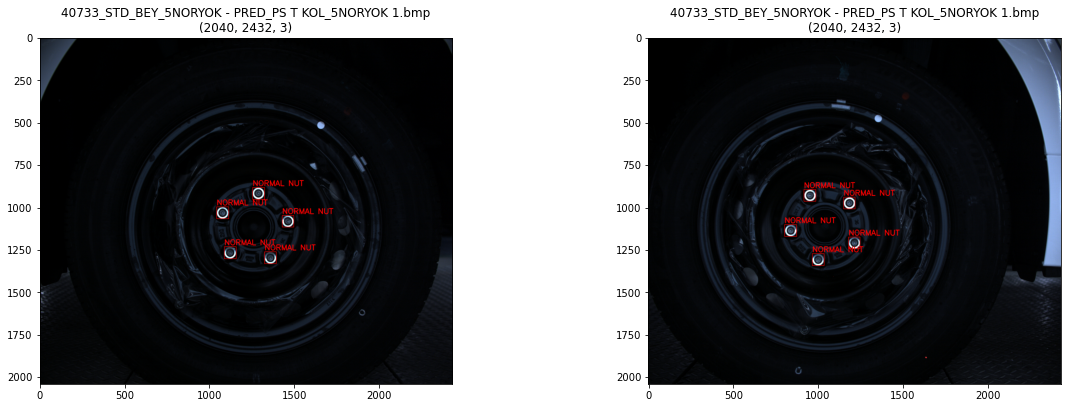

In [15]:
def plot_bboxes(x, y, bbox_labels=[""], indexes=[""], filenames=[""], bbox_format="albumentations", num_cols=3, plot_gap=2): 
    """
    Plot images with bboxes from array or dataframe 
    x: Image array generated by cv2.imread("img.jpg")[..., ::-1] or image_path column of dataframe 
    y: Array or dataframe column containing bboxes  
    bbox_labels: array or dataframe column containing labels for each bboxes 
    indexes: indexes of the images as a list you want to plot (e.g tinybox_indexes or [1, 64, 53]) 
    filenames: array or dataframe column containing filenames 
    bbox_format: "albumentations", "voc" or "yolo" based on bbox format of your data  
    """
    samples = [i for i in range(len(x))] if indexes[0] == "" else indexes.copy() 

    if isinstance(x, pd.Series): 
        y = [y.iloc[i] for i in samples] # Select only specific bbox indexes 
    elif isinstance(x, list) or isinstance(x, np.ndarray): 
        y = [y[i] for i in samples] # Select only specific bbox indexes 
    else:
        print("There's a problem with your image data format") 
        return

    # Turn bbox labels into desired list format 
    if bbox_labels[0] == "": 
        bbox_labels = [[""] * len(y[i]) for i in range(len(samples))] 
    elif isinstance(bbox_labels[0], str): 
        bbox_labels = [bbox_labels[i].split(",") for i in samples] 
    elif isinstance(bbox_labels[0], list): 
        bbox_labels = [bbox_labels[i] for i in samples] 
    else: 
        print("There's a problem with your label data format") 
        return 

    # Turn filenames into desired list format 
    filenames = [""] * len(samples) if filenames[0] == "" else [filenames[i] for i in samples] 

    # Turn images into array format 
    if isinstance(x, pd.Series): 
        x = [cv2.imread(x.iloc[i])[..., ::-1] for i in samples]
        width = [a.shape[1] for a in x] 
        height = [a.shape[0] for a in x]
    elif isinstance(x, list):
        x = [cv2.imread(x[i])[..., ::-1] for i in samples]
        width = [a.shape[1] for a in x] 
        height = [a.shape[0] for a in x]
    elif isinstance(x, np.ndarray): 
        x = np.array([x[i] for i in samples]) 
        width = [a.shape[1] for a in x] 
        height = [a.shape[0] for a in x] 
    else: 
        print("There's a problem with your image data format") 
        return 

    plt.figure(figsize=(20,len(samples)*plot_gap)) # Increase plot_gap if images nested together

    for i,bboxes in enumerate(y): 
        img = x[i] if x[i].max() <= 1 else x[i]/255 
        if len(bboxes) == 0: 
            plt.subplot(int(len(samples)/num_cols)+1,num_cols,i+1) 
            plt.title(str(filenames[i]) + "\n" + str(img.shape)) 
            plt.imshow(img) 
            continue 
        else: 
            for k, bbox in enumerate(bboxes): 
                if bbox_format=="albumentations": 
                    [x1,y1,x2,y2] = [bbox[0]*width[i], bbox[1]*height[i], bbox[2]*width[i], bbox[3]*height[i]] 
                    [x1,y1,x2,y2] = [int(x) for x in [x1,y1,x2,y2]] 
                elif bbox_format=="voc": 
                    [x1,y1,x2,y2] = bbox 
                    [x1,y1,x2,y2] = [int(x) for x in [x1,y1,x2,y2]] 
                if bbox_format=="yolo": 
                    xcenter, ycenter, w, h = bbox
                    x1 = int((xcenter - w / 2) * width[i])
                    x2 = int((xcenter + w / 2) * width[i])
                    y1 = int((ycenter - h / 2) * height[i])
                    y2 = int((ycenter + h / 2) * height[i])
                    if x1 < 0: x1 = 0
                    if x2 > width[i] - 1: x2 = width[i] - 1
                    if y1 < 0: y1 = 0
                    if y2 > height[i] - 1: y1 = height[i] - 1
                cv2.rectangle(img, (x1,y1), (x2,y2), (255,0,0), 2)
                cv2.putText(img, bbox_labels[i][k], (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,0,0), 4) 
                plt.title(str(filenames[i]) + "\n" + str(img.shape))
                plt.subplot(int(len(samples)/num_cols)+1,num_cols,i+1)
            plt.imshow(img) 

plot_bboxes(x=df["image_path"], y=df["bboxes"], bbox_labels=df["label"], filenames=df["file_name"], indexes=tinybox_indexes, bbox_format="yolo",num_cols=2, plot_gap=7)

# **8. Target / Label / Feature Formatting**

In [16]:
classes = sorted(list({x for l in df["label"] for x in l}))
classes

['NORMAL NUT',
 'PARLAK KLT NUT',
 'PARLAK NUT',
 'SIYAH KLT NUT',
 'SIYAH NUT',
 'YUVARLAK NUT']

In [17]:
from sklearn.preprocessing import LabelEncoder 
le = LabelEncoder() 
le.fit(classes)
df['label_ids'] = df["label"].apply(lambda x: le.transform(x))

In [18]:
import joblib
joblib.dump(le, "Hubnut_Detection_Label_Encoder.joblib") # ohe | le |lb

['Hubnut_Detection_Label_Encoder.joblib']

# **9. Data Formatting For YOLO**

In [19]:
df["label_path"] =  "../dataset/labels/" + df["file_name"].apply(lambda x: x.split(".")[0]) + ".txt"

# **10. Image Processing**

### **10.1 Only For Kaggle - If Image Processing Not Done**

In [20]:
def copy_images(*dir, dst='./dataset/images', im_size=['']):
    directories = [*dir]
    images = sum([glob(os.path.join(i,j), recursive=True) for j in ("**/*.png","**/*.jpg","**/*.jpeg","**/*.bmp") for i in directories],[])
    print('Copying %d images'%len(images))
    os.makedirs(dst, exist_ok=True)
    if im_size[0]!="":
        for image in images:
            try:
                img = cv2.resize(np.asarray(Image.open(image).convert('RGB')),im_size)
                pyplot.imsave(os.path.join(dst,os.path.split(image)[1]), img) 
            except Exception as e:
                print ("Unable to copy file. %s" % e)
    else:
        for image in images:
            try:
                # with open(image, 'rb') as fin,open(os.path.join(dst,image.split("/")[-1]), 'wb') as fout:
                    # shutil.copyfileobj(fin, fout, 128*1024) # Slightly faster than below one
                shutil.copyfile(src=image,dst=os.path.join(dst,os.path.split(image)[1]))
            except Exception as e:
                print ("Unable to copy file. %s" % e)
    if len(images)==len(os.listdir(dst)):
        print("All images were copied")
    else:
        print('%d images copied out of %d images'%(len(os.listdir(dst)),len(images)))

copy_images(dir1,dir2,dir3, dst='./dataset/images', im_size=(1280,1280))

Copying 1334 images
All images were copied


### **10.2 Only For Kaggle - Update Image Paths To New Relative Location**

In [21]:
df["image_path"] = "../dataset/images/" + df["file_name"]

# **11. Splitting Data Into Training, Test & Validation Sets**

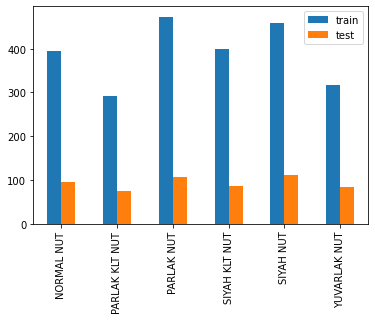

In [22]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, shuffle = True)

train_labels, train_counts = np.unique(sum(train_df["label"], []), return_counts=True)
test_labels, test_counts = np.unique(sum(test_df["label"], []), return_counts=True)

pd.DataFrame({'train': train_counts, 'test': test_counts},index=test_labels).plot.bar()  
plt.show()

# **12. Data Augmentation Of Training Data**

In [23]:
class ImageAugmentation:
    def __init__(self):
        pass

    @classmethod
    def preprocess(cls, x, im_size=[""], num_samples=0):
        num_samples=len(x) if num_samples==0 else num_samples
        if isinstance(x, pd.Series):
            if im_size[0]=="": return print("You must specify image size")
            x = [x.iloc[i] for i in range(len(x))] if num_samples==len(x) else [x.iloc[i] for i in random.sample(range(0, len(x)), num_samples)] 
            x = np.array([cv2.resize(np.asarray(Image.open(x[i])),im_size) for i in range(len(x))], dtype="uint8")
        elif isinstance(x, list):
            if im_size[0]=="": return print("You must specify image size")
            x = [x[i] for i in range(len(x))] if num_samples==len(x) else [x[i] for i in random.sample(range(0, len(x)), num_samples)] 
            x = np.array([cv2.resize(np.asarray(Image.open(x[i])),im_size) for i in range(len(x))], dtype="uint8")
        elif isinstance(x, np.ndarray):
            x = [x[i] for i in range(len(x))] if num_samples==len(x) else [x[i] for i in random.sample(range(0, len(x)), num_samples)]
            if im_size[0]!="": x = np.array([cv2.resize(x[i], im_size) for i in range(len(x))], dtype="uint8")
        else:
            print("There's a problem with your image data format")
            return
        return x,num_samples
    
    @classmethod
    def plotOrReturn(cls, x, mode, num_samples, num_cols, plot_gap):
        if mode == "plot":
            plt.figure(figsize=(23,num_samples*plot_gap))
            for i in random.sample(range(len(x)), num_samples):
                plt.subplot(int(num_samples/num_cols)+1,num_cols,i+1)
                plt.imshow(x[i-1]/255)
            plt.show()
        elif mode == "return":
            return np.array(x, dtype="uint8")
    
    @classmethod
    def save(cls, x, y=[""],z=[""], folder_name="dataset", sub_folder_name="images", im_size=[""], num_samples=0):
        """
        Save images in given folder
        x: Array containing images or dataframe column containing image paths
        y: Array, list or DF column containing labels for each image (save images for each label folder)
        z: Array, list or DF column containing names for each image (including format)
        folder_name: Name of the folder to be created in current directory to save the images
        sub_folder_name: Name of the folder to be created in folder_name to save the images
        im_size= if specified as (width,height), resize image
        """
        x,num_samples = cls.preprocess(x=x, num_samples=num_samples, im_size=im_size)
            
        if sub_folder_name==0:
            if not os.path.exists(folder_name):os.mkdir(folder_name)
        else:
            if not os.path.exists(folder_name): os.mkdir(folder_name)
            if not os.path.exists(os.path.join(folder_name,sub_folder_name)): os.mkdir(os.path.join(folder_name,sub_folder_name))
            folder_name = os.path.join(folder_name,sub_folder_name)
        
        for i in range(len(x)):
            if y[0] == '' and z[0] == '': # both z and y missing
                pyplot.imsave(os.path.join(folder_name,f"image {i}.png"), x[i])
            elif z[0] == '': # only y exist
                if not os.path.exists(os.path.join(folder_name,y[i])): os.mkdir(os.path.join(folder_name,y[i]))
                pyplot.imsave(os.path.join(folder_name,y[i],f"image {i}.png"), x[i])                
            elif y[0] == '': # only z exist
                pyplot.imsave(os.path.join(folder_name,z[i]), x[i])
            else: # both z and y exist
                if not os.path.exists(os.path.join(folder_name,y[i])): os.mkdir(os.path.join(folder_name,y[i]))
                pyplot.imsave(os.path.join(folder_name,y[i],z[i]), x[i])
            
    @classmethod
    def plot_augmentations_for_single_image(cls, x, im_size=[""], num_cols=5, plot_gap=1.1):
        """
        Plot augmentations for single image to pick best augmentations for dataset
        x: Array containing images or dataframe column containing image paths
        im_size= if specified as (width,height), resize image
        num_cols: Column size while plotting. Set it 2 or 3 to see more details
        plot_gap: To increase image size or if images nest together, increase plot_gap size
        """
        x,num_samples = cls.preprocess(x=x, num_samples=1, im_size=im_size)
        chosen_image = x[0].copy()
        
        albumentation_list = [ 
            A.Affine(always_apply=False, p=1), 
            A.AdvancedBlur(always_apply=False, p=1, blur_limit=(3, 13), sigmaX_limit=(0.2, 1.0), sigmaY_limit=(0.2, 1.0), rotate_limit=90, beta_limit=(0.5, 8.0), noise_limit=(0.9, 1.1)), 
            A.Blur(always_apply=False, p=1.0, blur_limit=(5, 10)), 
            A.CenterCrop(always_apply=False, p=1.0, height=150, width=150), 
            A.ChannelDropout(always_apply=False, p=1.0, channel_drop_range=(1, 2), fill_value=0), 
            A.ChannelShuffle(always_apply=False, p=1.0), 
            A.CLAHE(always_apply=False, p=1.0, clip_limit=(13, 21), tile_grid_size=(23, 10)), 
            A.ColorJitter(always_apply=False, p=1.0, brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2), 
            A.Crop(always_apply=False, p=1.0, x_min=0, y_min=0, x_max=200, y_max=200), 
            A.CropAndPad(p=1, percent=0.1), 
            A.CoarseDropout(always_apply=False, p=1.0, max_holes=50, max_height=15, max_width=15, min_holes=None, min_height=None, min_width=None, fill_value=0), 
            A.Downscale(always_apply=False, p=1.0, scale_min=0.15, scale_max=0.45, interpolation=0), 
            A.Equalize(always_apply=False, p=1.0, mode='cv', by_channels=True), 
            A.ElasticTransform(always_apply=False, p=1.0, alpha=1, sigma=50, alpha_affine=50, interpolation=1, border_mode=4, value=None, mask_value=None), 
            A.FancyPCA(always_apply=False, p=1.0, alpha=0.1), 
            A.Flip(always_apply=False, p=1), # Flip either horizontally, vertically or both horizontally and vertically. 
            A.GaussNoise(always_apply=False, p=1.0, var_limit=(150.0, 350.0), per_channel=True, mean=0.0), 
            A.GaussianBlur(always_apply=False, p=1.0, blur_limit=(3, 7), sigma_limit=0), 
            A.GlassBlur(always_apply=False, p=1.0, sigma=0.5, max_delta=3, iterations=1),
            A.GridDistortion(always_apply=False, p=1.0, num_steps=5, distort_limit=0.8, interpolation=1, border_mode=4), 
            A.GridDropout(always_apply=False, p=1.0, ratio=0.5, unit_size_min=10, unit_size_max=10, holes_number_x=10, holes_number_y=10, shift_x=0, shift_y=0, random_offset=False, fill_value=0, mask_fill_value=None), 
            A.HorizontalFlip(always_apply=False, p=1), 
            A.HueSaturationValue(always_apply=False, p=1.0, hue_shift_limit=(40, 50), sat_shift_limit=(20, 157), val_shift_limit=(-20, 50)), 
            A.ISONoise(always_apply=False, p=1.0, intensity=(0.1, 0.5), color_shift=(0.25, 0.85)), 
            A.MedianBlur(always_apply=False, p=1.0, blur_limit=7), 
            A.MotionBlur(always_apply=False, p=1.0, blur_limit=(25, 33)), 
            A.MultiplicativeNoise(always_apply=False, p=1.0, multiplier=(0.6, 1.7), per_channel=True, elementwise=True), 
            A.OpticalDistortion(always_apply=False, p=1.0, distort_limit=0.4, shift_limit=0.3, interpolation=1, border_mode=4, value=None, mask_value=None), 
            A.Perspective(always_apply=False, p=1.0, scale=(0.05, 0.1), keep_size=True, pad_mode=0, pad_val=0, mask_pad_val=0, fit_output=False, interpolation=1), 
            A.PiecewiseAffine(always_apply=False, p=1), 
            A.PixelDropout(always_apply=False, p=1, dropout_prob=0.35, drop_value=0), 
            A.Posterize(always_apply=False, p=1.0, num_bits=[(0, 5), (0, 8), (0, 6)]), 
            A.RandomBrightness(always_apply=False, p=1.0, limit=(-0.4, 0.5)), 
            A.RandomBrightnessContrast(always_apply=False, p=1.0, brightness_limit=(-0.4, 0.5), contrast_limit=(-0.4, 0.5), brightness_by_max=True), 
            A.RandomContrast(always_apply=False, p=1.0, limit=(-0.9, 0.9)), 
            A.RandomCrop(always_apply=False, p=1, height=200, width=200), 
            A.RandomFog(always_apply=False, p=1.0, fog_coef_lower=0.22, fog_coef_upper=0.38, alpha_coef=1.0), 
            A.RandomGamma(always_apply=False, p=1.0, gamma_limit=(35, 150), eps=None), 
            A.RandomGridShuffle(always_apply=False, p=1.0, grid=(3, 3)), 
            A.RandomRain(always_apply=False, p=1.0, slant_lower=-10, slant_upper=10, drop_length=20, drop_width=1, drop_color=(0, 0, 0), blur_value=4, brightness_coefficient=0.5, rain_type=None), 
            A.RandomResizedCrop(always_apply=False, p=1.0, height=150, width=150, scale=(0.08, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=0), 
            A.RandomRotate90(always_apply=False, p=1.0), 
            A.RandomShadow(always_apply=False, p=1.0, shadow_roi=(0, 0.5, 1, 1), num_shadows_lower=1, num_shadows_upper=2, shadow_dimension=5), 
            A.RandomSnow(always_apply=False, p=1.0, snow_point_lower=0.1, snow_point_upper=0.8, brightness_coeff=2.5), 
            A.RandomSunFlare(always_apply=False, p=1), 
            A.RandomToneCurve(always_apply=False, p=1, scale=0.8), 
            A.Resize(always_apply=False, p=1, height=500, width=500), # You normally don't need, but keep it just in case 
            A.RGBShift(always_apply=False, p=1.0, r_shift_limit=(29, 20), g_shift_limit=(-20, 150), b_shift_limit=(-20, 150)), 
            A.RingingOvershoot(always_apply=False, p=1.0, blur_limit=(7, 15), cutoff=(0.7853981633974483, 1.5707963267948966)), 
            A.Rotate(always_apply=False, p=1.0, limit=(-90, 90), crop_border=False), 
            A.SafeRotate(always_apply=False, p=1), 
            A.Sharpen(always_apply=False, p=1, alpha=(0.2, 0.5), lightness=(0.5, 1.0)), 
            A.ShiftScaleRotate(always_apply=False, p=1.0, rotate_limit=(-90, 90),rotate_method='largest_box'), 
            A.Solarize(always_apply=False, p=1.0, threshold=(150, 150)), 
            A.Superpixels(always_apply=False, p=1.0, p_replace=0.1, n_segments=100, max_size=128, interpolation=1), 
            A.Transpose(always_apply=False, p=1.0), 
            A.ToGray(always_apply=False, p=1.0), # Might come in handy later, don't use! 
            A.ToSepia(always_apply=False, p=1.0), 
            A.VerticalFlip(always_apply=False, p=1.0)] 
        
        titles_list = ["Original","Affine", "AdvancedBlur", "Blur","CenterCrop","ChannelDropout", 
               "ChannelShuffle", "CLAHE", "ColorJitter","Crop","CropAndPad", "Cutout",  
               "Downscale", "ElasticTransform","Equalize", "FancyPCA", "Flip", "GaussNoise",  
               "GaussianBlur", "GlassBlur", "GridDistortion", "GridDropout","HorizontalFlip",  
               "HueSaturationValue", "ISONoise", "MedianBlur","MotionBlur","MultiplicativeNoise",  
               "OpticalDistortion" , "Perspective","PiecewiseAffine", "PixelDropout", "Posterize", 
               "RandomBrightness", "RandomBrightnessContrast", "RandomContrast","RandomCrop",  
               "RandomFog", "RandomGamma", "RandomGridShuffle","RandomRain", "RandomResizedCrop",  
               "RandomRotate90", "RandomShadow", "RandomSnow", "RandomSunFlare", "RandomToneCurve", 
               "Resize", "RGBShift", "Rotate", "RingingOvershoot", "SafeRotate", "Sharpen", "ShiftScaleRotate",  
               "Solarize", "Superpixels","Transpose", "ToGray", "ToSepia", "VerticalFlip" ] 

        img_matrix_list = [] 
        for aug_type in albumentation_list: 
            img = aug_type(image = chosen_image)['image'] 
            img_matrix_list.append(img) 
        img_matrix_list.insert(0,chosen_image) #insert original image at the beginning
        plt.figure(figsize=(20,len(titles_list)*plot_gap)) # Increase 1.1 if images nested together 
        for i, (img, title) in enumerate(zip(img_matrix_list, titles_list)): 
            plt.subplot(int(len(titles_list)/num_cols)+1,num_cols,i+1) 
            plt.title(title, fontsize=15) 
            plt.imshow(img)
            
    @classmethod
    def augment_images(cls, x, im_size=[""], num_samples=0, num_cols=5, plot_gap=1.1, mode="plot"):
        """
        Create new batch from dataset after applying augmentation
        x: Array containing images or dataframe column containing image paths
        im_size= if specified as (width,height), resize image
        num_samples: If x is too large, you may only crop & plot few random samples
        num_cols: Column size while plotting. Set it 2 or 3 to see more details
        plot_gap: To increase image size or if images nest together, increase plot_gap size
        mode: plot → plot samples to find best parameters | return → returns new array with cropped imgs
        """
        x,num_samples = cls.preprocess(x=x, num_samples=num_samples, im_size=im_size)
        
        transform = A.Compose([
            A.SomeOf([ 
                A.Affine(always_apply=False, p=0.5), 
                A.AdvancedBlur(always_apply=False, p=0.5, blur_limit=(3, 13), sigmaX_limit=(0.2, 1.0), sigmaY_limit=(0.2, 1.0), rotate_limit=90, beta_limit=(0.5, 8.0), noise_limit=(0.9, 1.1)), 
                A.Blur(always_apply=False, p=0.5, blur_limit=(5, 10)), 
                A.CropAndPad(p=0.5, percent=0.1), 
                A.Equalize(always_apply=False, p=0.5, mode='cv', by_channels=True), 
                A.FancyPCA(always_apply=False, p=0.5, alpha=0.1), 
                A.Flip(always_apply=False, p=0.5), # Flip either horizontally, vertically or both horizontally and vertically. 
                A.GaussNoise(always_apply=False, p=0.5, var_limit=(150.0, 350.0), per_channel=True, mean=0.0), 
                A.GaussianBlur(always_apply=False, p=0.5, blur_limit=(3, 7), sigma_limit=0), 
                A.GlassBlur(always_apply=False, p=0.5, sigma=0.5, max_delta=3, iterations=1), 
                A.HorizontalFlip(always_apply=False, p=0.5), 
                A.ISONoise(always_apply=False, p=0.5, intensity=(0.1, 0.5), color_shift=(0.25, 0.85)), 
                A.MedianBlur(always_apply=False, p=0.5, blur_limit=7), 
                A.MotionBlur(always_apply=False, p=0.5, blur_limit=(25, 33)), 
                A.MultiplicativeNoise(always_apply=False, p=0.5, multiplier=(0.6, 1.7), per_channel=True, elementwise=True), 
                A.Perspective(always_apply=False, p=0.5, scale=(0.05, 0.1), keep_size=True, pad_mode=0, pad_val=0, mask_pad_val=0, fit_output=False, interpolation=1), 
                A.PiecewiseAffine(always_apply=False, p=0.5), 
                A.PixelDropout(always_apply=False, p=0.5, dropout_prob=0.15, drop_value=0), 
                A.RandomBrightnessContrast(always_apply=False, p=0.5, brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), brightness_by_max=True), 
                A.RandomContrast(always_apply=False, p=0.5, limit=(-0.9, 0.9)), 
                A.RandomGamma(always_apply=False, p=0.5, gamma_limit=(35, 150), eps=None), 
                A.RandomRain(always_apply=False, p=0.5, slant_lower=-10, slant_upper=10, drop_length=20, drop_width=1, drop_color=(0, 0, 0), blur_value=4, brightness_coefficient=0.5, rain_type=None), 
                A.RandomResizedCrop(always_apply=False, p=0.5, height=1280, width=1280, scale=(0.08, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=0), 
                A.RandomRotate90(always_apply=False, p=0.5), 
                A.RandomShadow(always_apply=False, p=0.5, shadow_roi=(0, 0.5, 1, 1), num_shadows_lower=1, num_shadows_upper=2, shadow_dimension=5), 
                A.RingingOvershoot(always_apply=False, p=0.5, blur_limit=(7, 15), cutoff=(0.7853981633974483, 1.5707963267948966)), 
                A.Rotate(always_apply=False, p=0.5, limit=(-90, 90), method='largest_box', crop_border=False), 
                A.SafeRotate(always_apply=False, p=0.5), 
                A.Sharpen(always_apply=False, p=0.5, alpha=(0.2, 0.5), lightness=(0.5, 1.0)), 
                A.ShiftScaleRotate(always_apply=False, p=0.5, rotate_limit=(-90, 90),rotate_method='largest_box'), 
                A.Transpose(always_apply=False, p=0.5), 
                A.VerticalFlip(always_apply=False, p=0.5)
            ], 2, replace=False, p=1) # Pick 5 augmentations from above, you can change 5
        ])
        
        x_aug = [] 
        for i in range(len(x)):
            image = x[i].copy()
            transformed = transform(image=image)
            if np.isnan(transformed['image']).any() or transformed['image'].max() > 255: 
                continue
            else:
                x_aug.append(transformed['image'])
                
        x_aug = np.array(x_aug)
        
        return cls.plotOrReturn(x_aug, mode, num_samples, num_cols, plot_gap)

In [24]:
# ImageAugmentation.plot_augmentations_for_single_image([fp.split("../")[-1] for fp in train_df["image_path"]], im_size=img_size,num_cols=2,plot_gap=5)

In [25]:
%%writefile yolov5/utils/augmentations.py 
# YOLOv5 🚀 by Ultralytics, GPL-3.0 license
"""
Image augmentation functions
"""

import math
import random

import cv2
import numpy as np
import torch
import torchvision.transforms as T
import torchvision.transforms.functional as TF

from utils.general import LOGGER, check_version, colorstr, resample_segments, segment2box, xywhn2xyxy
from utils.metrics import bbox_ioa

IMAGENET_MEAN = 0.485, 0.456, 0.406  # RGB mean
IMAGENET_STD = 0.229, 0.224, 0.225  # RGB standard deviation


class Albumentations:
    # YOLOv5 Albumentations class (optional, only used if package is installed)
    def __init__(self, size=640):
        self.transform = None
        prefix = colorstr('albumentations: ')
        try:
            import albumentations as A
            check_version(A.__version__, '1.0.3', hard=True)  # version requirement

            T = [
                A.SomeOf([ 
                    A.Affine(always_apply=False, p=0.5), 
                    A.AdvancedBlur(always_apply=False, p=0.5, blur_limit=(3, 13), sigmaX_limit=(0.2, 1.0), sigmaY_limit=(0.2, 1.0), rotate_limit=90, beta_limit=(0.5, 8.0), noise_limit=(0.9, 1.1)), 
                    A.Blur(always_apply=False, p=0.5, blur_limit=(5, 10)), 
                    A.CropAndPad(p=0.5, percent=0.2), 
                    A.Flip(always_apply=False, p=0.5), # Flip either horizontally, vertically or both horizontally and vertically. 
                    A.GaussNoise(always_apply=False, p=0.5, var_limit=(150.0, 350.0), per_channel=True, mean=0.0), 
                    A.GaussianBlur(always_apply=False, p=0.5, blur_limit=(3, 7), sigma_limit=0), 
                    A.GlassBlur(always_apply=False, p=0.5, sigma=0.5, max_delta=3, iterations=1), 
                    A.HorizontalFlip(always_apply=False, p=0.5), 
                    A.MedianBlur(always_apply=False, p=0.5, blur_limit=7), 
                    A.MotionBlur(always_apply=False, p=0.5, blur_limit=(25, 33)), 
                    A.MultiplicativeNoise(always_apply=False, p=0.5, multiplier=(0.6, 1.7), per_channel=True, elementwise=True), 
                    A.Perspective(always_apply=False, p=0.5, scale=(0.05, 0.1), keep_size=True, pad_mode=0, pad_val=0, mask_pad_val=0, fit_output=False, interpolation=1), 
                    A.PiecewiseAffine(always_apply=False, p=0.5), 
                    A.PixelDropout(always_apply=False, p=0.5, dropout_prob=0.15, drop_value=0), 
                    A.RandomBrightnessContrast(always_apply=False, p=0.5, brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), brightness_by_max=True), 
                    A.RandomContrast(always_apply=False, p=0.5, limit=(-0.9, 0.9)), 
                    A.RandomGamma(always_apply=False, p=0.5, gamma_limit=(35, 150), eps=None), 
                    A.RandomRain(always_apply=False, p=0.5, slant_lower=-10, slant_upper=10, drop_length=20, drop_width=1, drop_color=(0, 0, 0), blur_value=4, brightness_coefficient=0.5, rain_type=None), 
                    A.RandomRotate90(always_apply=False, p=0.5), 
                    A.RandomShadow(always_apply=False, p=0.5, shadow_roi=(0, 0.5, 1, 1), num_shadows_lower=1, num_shadows_upper=2, shadow_dimension=5), 
                    A.Rotate(always_apply=False, p=0.5, limit=(-90, 90), method='largest_box', crop_border=False), 
                    A.Sharpen(always_apply=False, p=0.5, alpha=(0.2, 0.5), lightness=(0.5, 1.0)), 
                    A.Transpose(always_apply=False, p=0.5), 
                    A.VerticalFlip(always_apply=False, p=0.5),
                    A.RandomResizedCrop(always_apply=False, p=0.5, height=1280, width=1280, scale=(0.1, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=0),
                ], 1, replace=False, p=1) # Pick 2 augmentations from above, you can change 2
            ]  # transforms
            self.transform = A.Compose(T, bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

            LOGGER.info(prefix + ', '.join(f'{x}'.replace('always_apply=False, ', '') for x in T if x.p))
        except ImportError:  # package not installed, skip
            pass
        except Exception as e:
            LOGGER.info(f'{prefix}{e}')

    def __call__(self, im, labels, p=1.0):
        if self.transform and random.random() < p:
            new = self.transform(image=im, bboxes=labels[:, 1:], class_labels=labels[:, 0])  # transformed
            im, labels = new['image'], np.array([[c, *b] for c, b in zip(new['class_labels'], new['bboxes'])])
        return im, labels


def normalize(x, mean=IMAGENET_MEAN, std=IMAGENET_STD, inplace=False):
    # Denormalize RGB images x per ImageNet stats in BCHW format, i.e. = (x - mean) / std
    return TF.normalize(x, mean, std, inplace=inplace)


def denormalize(x, mean=IMAGENET_MEAN, std=IMAGENET_STD):
    # Denormalize RGB images x per ImageNet stats in BCHW format, i.e. = x * std + mean
    for i in range(3):
        x[:, i] = x[:, i] * std[i] + mean[i]
    return x


def augment_hsv(im, hgain=0.5, sgain=0.5, vgain=0.5):
    # HSV color-space augmentation
    if hgain or sgain or vgain:
        r = np.random.uniform(-1, 1, 3) * [hgain, sgain, vgain] + 1  # random gains
        hue, sat, val = cv2.split(cv2.cvtColor(im, cv2.COLOR_BGR2HSV))
        dtype = im.dtype  # uint8

        x = np.arange(0, 256, dtype=r.dtype)
        lut_hue = ((x * r[0]) % 180).astype(dtype)
        lut_sat = np.clip(x * r[1], 0, 255).astype(dtype)
        lut_val = np.clip(x * r[2], 0, 255).astype(dtype)

        im_hsv = cv2.merge((cv2.LUT(hue, lut_hue), cv2.LUT(sat, lut_sat), cv2.LUT(val, lut_val)))
        cv2.cvtColor(im_hsv, cv2.COLOR_HSV2BGR, dst=im)  # no return needed


def hist_equalize(im, clahe=True, bgr=False):
    # Equalize histogram on BGR image 'im' with im.shape(n,m,3) and range 0-255
    yuv = cv2.cvtColor(im, cv2.COLOR_BGR2YUV if bgr else cv2.COLOR_RGB2YUV)
    if clahe:
        c = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        yuv[:, :, 0] = c.apply(yuv[:, :, 0])
    else:
        yuv[:, :, 0] = cv2.equalizeHist(yuv[:, :, 0])  # equalize Y channel histogram
    return cv2.cvtColor(yuv, cv2.COLOR_YUV2BGR if bgr else cv2.COLOR_YUV2RGB)  # convert YUV image to RGB


def replicate(im, labels):
    # Replicate labels
    h, w = im.shape[:2]
    boxes = labels[:, 1:].astype(int)
    x1, y1, x2, y2 = boxes.T
    s = ((x2 - x1) + (y2 - y1)) / 2  # side length (pixels)
    for i in s.argsort()[:round(s.size * 0.5)]:  # smallest indices
        x1b, y1b, x2b, y2b = boxes[i]
        bh, bw = y2b - y1b, x2b - x1b
        yc, xc = int(random.uniform(0, h - bh)), int(random.uniform(0, w - bw))  # offset x, y
        x1a, y1a, x2a, y2a = [xc, yc, xc + bw, yc + bh]
        im[y1a:y2a, x1a:x2a] = im[y1b:y2b, x1b:x2b]  # im4[ymin:ymax, xmin:xmax]
        labels = np.append(labels, [[labels[i, 0], x1a, y1a, x2a, y2a]], axis=0)

    return im, labels


def letterbox(im, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleFill=False, scaleup=True, stride=32):
    # Resize and pad image while meeting stride-multiple constraints
    shape = im.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better val mAP)
        r = min(r, 1.0)

    # Compute padding
    ratio = r, r  # width, height ratios
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding
    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # wh padding
    elif scaleFill:  # stretch
        dw, dh = 0.0, 0.0
        new_unpad = (new_shape[1], new_shape[0])
        ratio = new_shape[1] / shape[1], new_shape[0] / shape[0]  # width, height ratios

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        im = cv2.resize(im, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
    return im, ratio, (dw, dh)


def random_perspective(im,
                       targets=(),
                       segments=(),
                       degrees=10,
                       translate=.1,
                       scale=.1,
                       shear=10,
                       perspective=0.0,
                       border=(0, 0)):
    # torchvision.transforms.RandomAffine(degrees=(-10, 10), translate=(0.1, 0.1), scale=(0.9, 1.1), shear=(-10, 10))
    # targets = [cls, xyxy]

    height = im.shape[0] + border[0] * 2  # shape(h,w,c)
    width = im.shape[1] + border[1] * 2

    # Center
    C = np.eye(3)
    C[0, 2] = -im.shape[1] / 2  # x translation (pixels)
    C[1, 2] = -im.shape[0] / 2  # y translation (pixels)

    # Perspective
    P = np.eye(3)
    P[2, 0] = random.uniform(-perspective, perspective)  # x perspective (about y)
    P[2, 1] = random.uniform(-perspective, perspective)  # y perspective (about x)

    # Rotation and Scale
    R = np.eye(3)
    a = random.uniform(-degrees, degrees)
    # a += random.choice([-180, -90, 0, 90])  # add 90deg rotations to small rotations
    s = random.uniform(1 - scale, 1 + scale)
    # s = 2 ** random.uniform(-scale, scale)
    R[:2] = cv2.getRotationMatrix2D(angle=a, center=(0, 0), scale=s)

    # Shear
    S = np.eye(3)
    S[0, 1] = math.tan(random.uniform(-shear, shear) * math.pi / 180)  # x shear (deg)
    S[1, 0] = math.tan(random.uniform(-shear, shear) * math.pi / 180)  # y shear (deg)

    # Translation
    T = np.eye(3)
    T[0, 2] = random.uniform(0.5 - translate, 0.5 + translate) * width  # x translation (pixels)
    T[1, 2] = random.uniform(0.5 - translate, 0.5 + translate) * height  # y translation (pixels)

    # Combined rotation matrix
    M = T @ S @ R @ P @ C  # order of operations (right to left) is IMPORTANT
    if (border[0] != 0) or (border[1] != 0) or (M != np.eye(3)).any():  # image changed
        if perspective:
            im = cv2.warpPerspective(im, M, dsize=(width, height), borderValue=(114, 114, 114))
        else:  # affine
            im = cv2.warpAffine(im, M[:2], dsize=(width, height), borderValue=(114, 114, 114))

    # Visualize
    # import matplotlib.pyplot as plt
    # ax = plt.subplots(1, 2, figsize=(12, 6))[1].ravel()
    # ax[0].imshow(im[:, :, ::-1])  # base
    # ax[1].imshow(im2[:, :, ::-1])  # warped

    # Transform label coordinates
    n = len(targets)
    if n:
        use_segments = any(x.any() for x in segments)
        new = np.zeros((n, 4))
        if use_segments:  # warp segments
            segments = resample_segments(segments)  # upsample
            for i, segment in enumerate(segments):
                xy = np.ones((len(segment), 3))
                xy[:, :2] = segment
                xy = xy @ M.T  # transform
                xy = xy[:, :2] / xy[:, 2:3] if perspective else xy[:, :2]  # perspective rescale or affine

                # clip
                new[i] = segment2box(xy, width, height)

        else:  # warp boxes
            xy = np.ones((n * 4, 3))
            xy[:, :2] = targets[:, [1, 2, 3, 4, 1, 4, 3, 2]].reshape(n * 4, 2)  # x1y1, x2y2, x1y2, x2y1
            xy = xy @ M.T  # transform
            xy = (xy[:, :2] / xy[:, 2:3] if perspective else xy[:, :2]).reshape(n, 8)  # perspective rescale or affine

            # create new boxes
            x = xy[:, [0, 2, 4, 6]]
            y = xy[:, [1, 3, 5, 7]]
            new = np.concatenate((x.min(1), y.min(1), x.max(1), y.max(1))).reshape(4, n).T

            # clip
            new[:, [0, 2]] = new[:, [0, 2]].clip(0, width)
            new[:, [1, 3]] = new[:, [1, 3]].clip(0, height)

        # filter candidates
        i = box_candidates(box1=targets[:, 1:5].T * s, box2=new.T, area_thr=0.01 if use_segments else 0.10)
        targets = targets[i]
        targets[:, 1:5] = new[i]

    return im, targets


def copy_paste(im, labels, segments, p=0.5):
    # Implement Copy-Paste augmentation https://arxiv.org/abs/2012.07177, labels as nx5 np.array(cls, xyxy)
    n = len(segments)
    if p and n:
        h, w, c = im.shape  # height, width, channels
        im_new = np.zeros(im.shape, np.uint8)
        for j in random.sample(range(n), k=round(p * n)):
            l, s = labels[j], segments[j]
            box = w - l[3], l[2], w - l[1], l[4]
            ioa = bbox_ioa(box, labels[:, 1:5])  # intersection over area
            if (ioa < 0.30).all():  # allow 30% obscuration of existing labels
                labels = np.concatenate((labels, [[l[0], *box]]), 0)
                segments.append(np.concatenate((w - s[:, 0:1], s[:, 1:2]), 1))
                cv2.drawContours(im_new, [segments[j].astype(np.int32)], -1, (255, 255, 255), cv2.FILLED)

        result = cv2.bitwise_and(src1=im, src2=im_new)
        result = cv2.flip(result, 1)  # augment segments (flip left-right)
        i = result > 0  # pixels to replace
        # i[:, :] = result.max(2).reshape(h, w, 1)  # act over ch
        im[i] = result[i]  # cv2.imwrite('debug.jpg', im)  # debug

    return im, labels, segments


def cutout(im, labels, p=0.5):
    # Applies image cutout augmentation https://arxiv.org/abs/1708.04552
    if random.random() < p:
        h, w = im.shape[:2]
        scales = [0.5] * 1 + [0.25] * 2 + [0.125] * 4 + [0.0625] * 8 + [0.03125] * 16  # image size fraction
        for s in scales:
            mask_h = random.randint(1, int(h * s))  # create random masks
            mask_w = random.randint(1, int(w * s))

            # box
            xmin = max(0, random.randint(0, w) - mask_w // 2)
            ymin = max(0, random.randint(0, h) - mask_h // 2)
            xmax = min(w, xmin + mask_w)
            ymax = min(h, ymin + mask_h)

            # apply random color mask
            im[ymin:ymax, xmin:xmax] = [random.randint(64, 191) for _ in range(3)]

            # return unobscured labels
            if len(labels) and s > 0.03:
                box = np.array([xmin, ymin, xmax, ymax], dtype=np.float32)
                ioa = bbox_ioa(box, xywhn2xyxy(labels[:, 1:5], w, h))  # intersection over area
                labels = labels[ioa < 0.60]  # remove >60% obscured labels

    return labels


def mixup(im, labels, im2, labels2):
    # Applies MixUp augmentation https://arxiv.org/pdf/1710.09412.pdf
    r = np.random.beta(32.0, 32.0)  # mixup ratio, alpha=beta=32.0
    im = (im * r + im2 * (1 - r)).astype(np.uint8)
    labels = np.concatenate((labels, labels2), 0)
    return im, labels


def box_candidates(box1, box2, wh_thr=2, ar_thr=100, area_thr=0.1, eps=1e-16):  # box1(4,n), box2(4,n)
    # Compute candidate boxes: box1 before augment, box2 after augment, wh_thr (pixels), aspect_ratio_thr, area_ratio
    w1, h1 = box1[2] - box1[0], box1[3] - box1[1]
    w2, h2 = box2[2] - box2[0], box2[3] - box2[1]
    ar = np.maximum(w2 / (h2 + eps), h2 / (w2 + eps))  # aspect ratio
    return (w2 > wh_thr) & (h2 > wh_thr) & (w2 * h2 / (w1 * h1 + eps) > area_thr) & (ar < ar_thr)  # candidates


def classify_albumentations(
        augment=True,
        size=224,
        scale=(0.08, 1.0),
        ratio=(0.75, 1.0 / 0.75),  # 0.75, 1.33
        hflip=0.5,
        vflip=0.0,
        jitter=0.4,
        mean=IMAGENET_MEAN,
        std=IMAGENET_STD,
        auto_aug=False):
    # YOLOv5 classification Albumentations (optional, only used if package is installed)
    prefix = colorstr('albumentations: ')
    try:
        import albumentations as A
        from albumentations.pytorch import ToTensorV2
        check_version(A.__version__, '1.0.3', hard=True)  # version requirement
        if augment:  # Resize and crop
            T = [A.RandomResizedCrop(height=size, width=size, scale=scale, ratio=ratio)]
            if auto_aug:
                # TODO: implement AugMix, AutoAug & RandAug in albumentation
                LOGGER.info(f'{prefix}auto augmentations are currently not supported')
            else:
                if hflip > 0:
                    T += [A.HorizontalFlip(p=hflip)]
                if vflip > 0:
                    T += [A.VerticalFlip(p=vflip)]
                if jitter > 0:
                    color_jitter = (float(jitter),) * 3  # repeat value for brightness, contrast, satuaration, 0 hue
                    T += [A.ColorJitter(*color_jitter, 0)]
        else:  # Use fixed crop for eval set (reproducibility)
            T = [A.SmallestMaxSize(max_size=size), A.CenterCrop(height=size, width=size)]
        T += [A.Normalize(mean=mean, std=std), ToTensorV2()]  # Normalize and convert to Tensor
        LOGGER.info(prefix + ', '.join(f'{x}'.replace('always_apply=False, ', '') for x in T if x.p))
        return A.Compose(T)

    except ImportError:  # package not installed, skip
        LOGGER.warning(f'{prefix}⚠️ not found, install with `pip install albumentations` (recommended)')
    except Exception as e:
        LOGGER.info(f'{prefix}{e}')


def classify_transforms(size=224):
    # Transforms to apply if albumentations not installed
    assert isinstance(size, int), f'ERROR: classify_transforms size {size} must be integer, not (list, tuple)'
    # T.Compose([T.ToTensor(), T.Resize(size), T.CenterCrop(size), T.Normalize(IMAGENET_MEAN, IMAGENET_STD)])
    return T.Compose([CenterCrop(size), ToTensor(), T.Normalize(IMAGENET_MEAN, IMAGENET_STD)])


class LetterBox:
    # YOLOv5 LetterBox class for image preprocessing, i.e. T.Compose([LetterBox(size), ToTensor()])
    def __init__(self, size=(640, 640), auto=False, stride=32):
        super().__init__()
        self.h, self.w = (size, size) if isinstance(size, int) else size
        self.auto = auto  # pass max size integer, automatically solve for short side using stride
        self.stride = stride  # used with auto

    def __call__(self, im):  # im = np.array HWC
        imh, imw = im.shape[:2]
        r = min(self.h / imh, self.w / imw)  # ratio of new/old
        h, w = round(imh * r), round(imw * r)  # resized image
        hs, ws = (math.ceil(x / self.stride) * self.stride for x in (h, w)) if self.auto else self.h, self.w
        top, left = round((hs - h) / 2 - 0.1), round((ws - w) / 2 - 0.1)
        im_out = np.full((self.h, self.w, 3), 114, dtype=im.dtype)
        im_out[top:top + h, left:left + w] = cv2.resize(im, (w, h), interpolation=cv2.INTER_LINEAR)
        return im_out


class CenterCrop:
    # YOLOv5 CenterCrop class for image preprocessing, i.e. T.Compose([CenterCrop(size), ToTensor()])
    def __init__(self, size=640):
        super().__init__()
        self.h, self.w = (size, size) if isinstance(size, int) else size

    def __call__(self, im):  # im = np.array HWC
        imh, imw = im.shape[:2]
        m = min(imh, imw)  # min dimension
        top, left = (imh - m) // 2, (imw - m) // 2
        return cv2.resize(im[top:top + m, left:left + m], (self.w, self.h), interpolation=cv2.INTER_LINEAR)


class ToTensor:
    # YOLOv5 ToTensor class for image preprocessing, i.e. T.Compose([LetterBox(size), ToTensor()])
    def __init__(self, half=False):
        super().__init__()
        self.half = half

    def __call__(self, im):  # im = np.array HWC in BGR order
        im = np.ascontiguousarray(im.transpose((2, 0, 1))[::-1])  # HWC to CHW -> BGR to RGB -> contiguous
        im = torch.from_numpy(im)  # to torch
        im = im.half() if self.half else im.float()  # uint8 to fp16/32
        im /= 255.0  # 0-255 to 0.0-1.0
        return im

Overwriting yolov5/utils/augmentations.py


# **13. Directory Formatting For YOLO**

In [26]:
if not os.path.exists('dataset'): os.mkdir("dataset")
if not os.path.exists('dataset/images'): os.mkdir("dataset/images") 
if not os.path.exists('dataset/labels'): os.mkdir("dataset/labels")

In [27]:
def yolo2txt(df,class_column,yolo_column,labels_column): 
    """ 
    Create txt file for each row in label column 
    df: Name of the dataframe 
    class_column: name of the column as string that contains class as [0],[1,2].. for each row 
    yolo_column: name of the column as string that contains yolo annots for each row 
    labels_column: name of the column as string that contains labels path for each row 
    """ 
    for i in range(len(df)): 
        with open("/".join(df[labels_column][i].split("/")[1:]), 'w') as file:
            if len(df[yolo_column].iloc[i]) == 0:  
                file.write("")  
                continue  
            for k in range(len(df[yolo_column].iloc[i])):  
                annot = str(df[class_column].iloc[i][k]) + " " + " ".join(str(i) for i in df[yolo_column].iloc[i][k]) + ("" if k+1 == len(df[yolo_column].iloc[i]) else "\n")  
                file.write(annot)
    if len(os.listdir("./dataset/images")) == len(os.listdir("./dataset/labels")):
        print('Operation successful. Txt file created for every image - even for images w/o annotations')
    else:
        print('Problem occured. Could not create txt file for some images.')
yolo2txt(df,"label_ids","bboxes","label_path")

Operation successful. Txt file created for every image - even for images w/o annotations


In [28]:
le.inverse_transform([0])

array(['NORMAL NUT'], dtype='<U14')

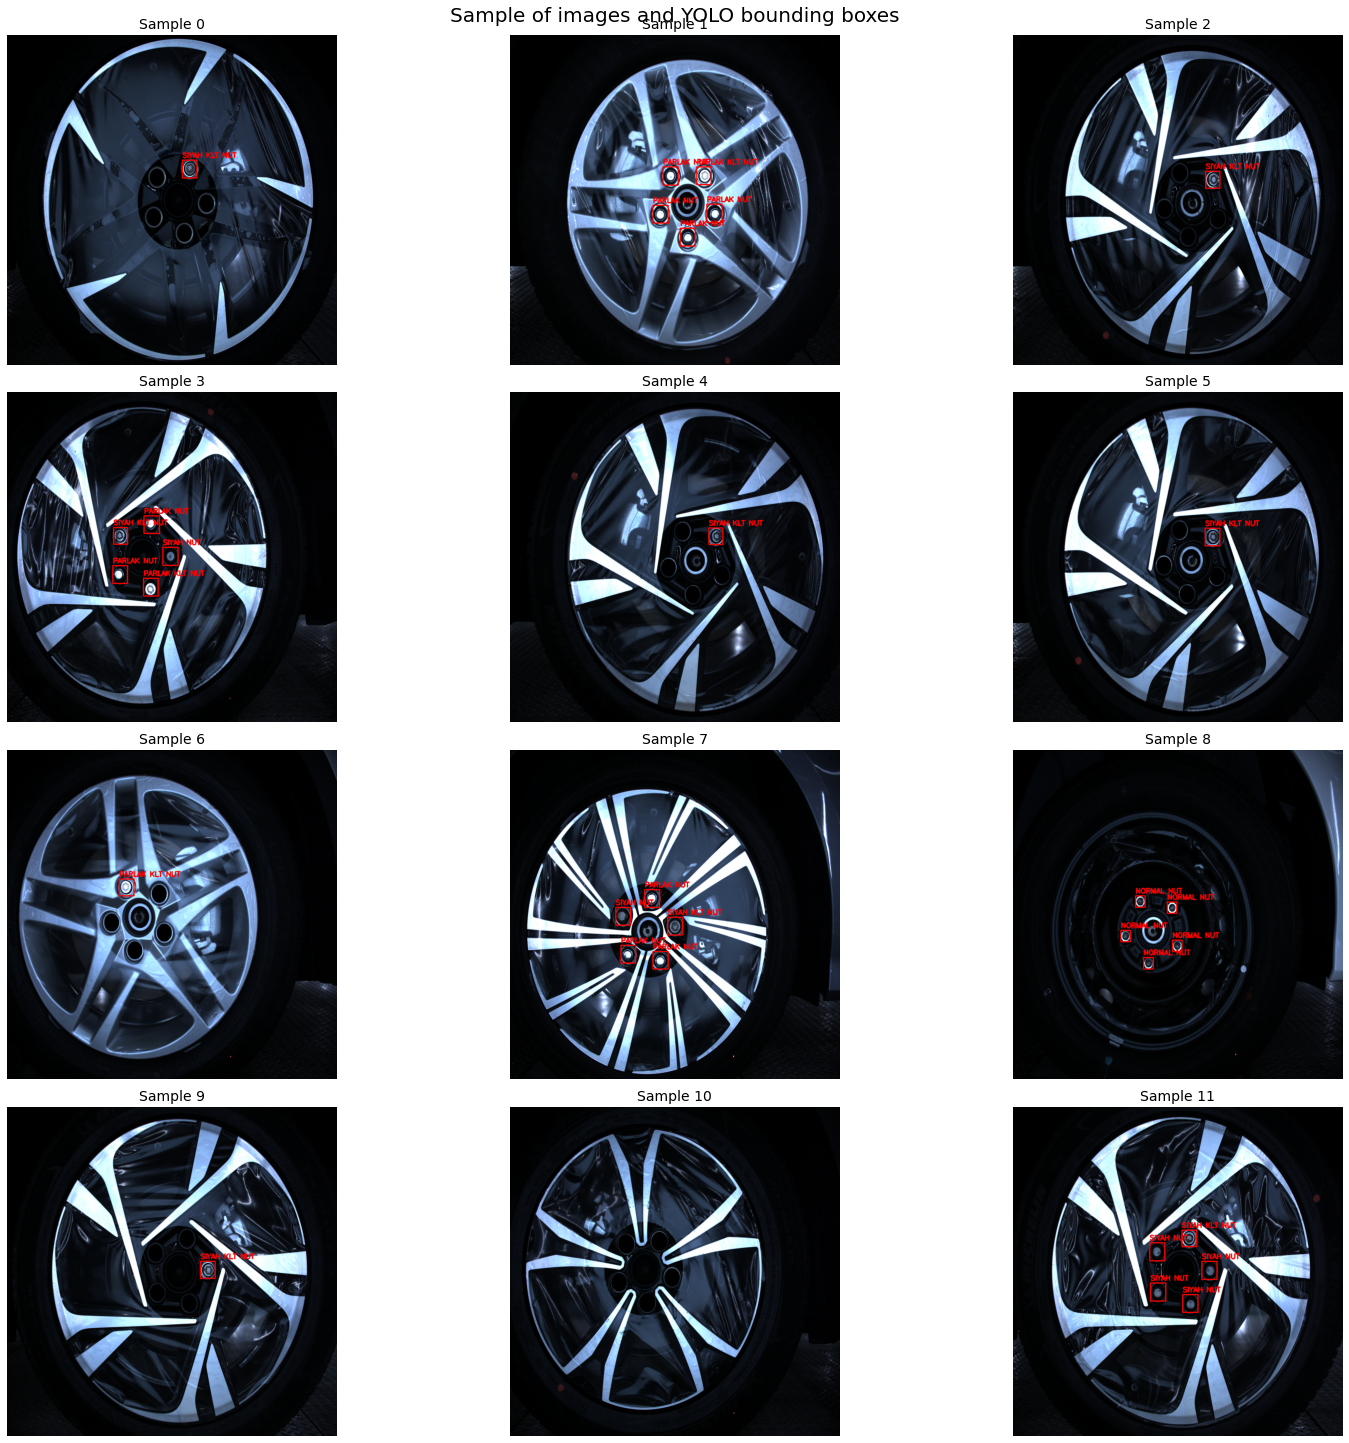

In [29]:
def view_yolo_samples(image_dir, label_dir, num_samples=30):
    images = [image_dir + "/" + image for image in random.sample(os.listdir(image_dir),num_samples)] 
    labels = [label_dir + "/" + image.split(".")[-2].split("/")[-1] + ".txt" for image in images] 
    # Plot  
    fig, axs = plt.subplots(int((num_samples/3)), 3, figsize=(23, num_samples*1.7)) #Increase 1.7  
    axs = axs.flatten()  
    fig.suptitle(f"Sample of images and YOLO bounding boxes", fontsize = 20)  
    for i in range(num_samples):  
        im = cv2.imread(images[i])  
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)  
        dh, dw, _ = im.shape  
        txt = open(labels[i], "r").read().split("\n")
        no_boxes = int(len(txt)) 
        # Draw boxes
        if txt[0] != "":
            for k in range(len(txt)):  
                box = txt[k].split(" ")[1:] #exlude class name 
                x, y, w, h = box  
                x, y, w, h = float(x), float(y), float(w), float(h)  
                l = int((x - w / 2) * dw)  
                r = int((x + w / 2) * dw)  
                t = int((y - h / 2) * dh)  
                b = int((y + h / 2) * dh)  
                if l < 0: l = 0  
                if r > dw - 1: r = dw - 1  
                if t < 0: t = 0  
                if b > dh - 1: b = dh - 1
                class_name = le.inverse_transform([int(txt[k].split(" ")[0])])
                cv2.rectangle(im, (l, t), (r, b), (255,0,0), 3)
                cv2.putText(im, class_name[0], (l, t-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255,0,0), 3)  
            # Show image with bboxes  
            axs[i].set_title(f"Sample {i}", fontsize = 14)  
            axs[i].imshow(im)  
            axs[i].set_axis_off()
        else:
            axs[i].set_title(f"Sample {i}", fontsize = 14)  
            axs[i].imshow(im)  
            axs[i].set_axis_off()
    plt.tight_layout()  
    plt.show()
view_yolo_samples("dataset/images","dataset/labels",12)

# **14. Configuration Setup For YOLO**

In [30]:
import yaml
with open("train_images.txt", "w") as file: 
    for path in list(train_df["image_path"]): 
        file.write(path + "\n")
        
with open("val_images.txt", "w") as file: 
    for path in list(test_df["image_path"]): 
        file.write(path + "\n")
        
config = {
    'train': '../train_images.txt', # train images relative to path to YOLO's train.py file 
    'val': '../val_images.txt', # val images relative to path to YOLO's train.py file 
    'nc': len(classes), # Number of classes 
    'names': classes} # Name of the classes 

with open("hubnut.yaml", "w") as file: # Name of the file (cots.yaml) will be used later on 
    yaml.dump(config, file, default_flow_style=None, sort_keys=False)

# **15. Delete Unused Variables**

In [31]:
import gc

del df

gc.collect()

34893

# **16. YOLO Training**

In [32]:
%cd yolov5/

/kaggle/working/yolov5


In [33]:
!wandb disabled 

W&B disabled.


In [34]:
!python train.py --img 1280 --batch 8 --epochs 200 --data ../hubnut.yaml --weights yolov5s.pt --cache

train: weights=yolov5s.pt, cfg=, data=../hubnut.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=200, batch_size=8, imgsz=1280, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: skipping check (not a git repository), for updates see https://github.com/ultralytics/yolov5
YOLOv5 🚀 2023-2-1 Python-3.7.12 torch-1.11.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0

In [35]:
import shutil
shutil.copy("./runs/train/exp/weights/best.pt", "../best.pt")

'../best.pt'